First, we try things out without transforming the mesh. We want to get rid of the Piola transformations. In the case of a non-transformed mesh this should not make a difference.

We solve the Helmholtz equation using a broken element ansatz, enforcing H(div)-continuity by introducing an additional trace space.

In [1]:
import matplotlib.pyplot as plt
from firedrake import *
import petsc4py.PETSc as PETSc
PETSc.Sys.popErrorHandler()

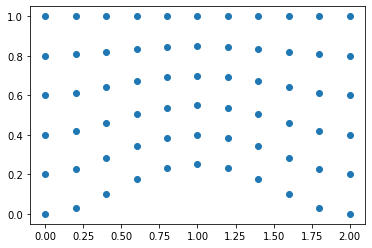

In [2]:
m = IntervalMesh(10,2)
mesh = ExtrudedMesh(m, 5, extrusion_type='uniform')

Vc = mesh.coordinates.function_space()
x, y = SpatialCoordinate(mesh)
f = Function(Vc).interpolate(as_vector([x, y + ( 0.25 * x**4 -x**3 + x**2) * (1-y) ] ) )
mesh.coordinates.assign(f)

xs = [mesh.coordinates.dat.data[i][0] for i in range(0,66)]
ys = [mesh.coordinates.dat.data[i][1] for i in range(0,66)]

plt.scatter(xs, ys)


In [3]:
element = FiniteElement("RTCF", cell="quadrilateral", degree=1)
element._mapping = 'identity'
Sigma = FunctionSpace(mesh, element)
V = FunctionSpace(mesh, "DG", 0)


Find $(\sigma, u, \lambda)$ in $\hat{\Sigma} \times V \times T$ such that 

$$
\begin{align}
\int_\Omega (\sigma \cdot \tau + \nabla \cdot \tau u)\,\text{d} x + \langle [[ \tau ]], \lambda \rangle_{\partial \mathcal{T}_h \setminus \Gamma_D} &= 
  \int_\Gamma \tau \cdot n u\,\text{d}s \quad \forall \tau \in \hat{\Sigma}\\ 
\int_\Omega (\nabla\cdot\sigma)v + v u\,\text{d} x &= - \int_\Omega f v\,\text{d}x 
\quad \forall v \in V\\
\langle \gamma, [[ \sigma ]] \rangle_{\partial \mathcal{T}_h \setminus \Gamma_D} &= \langle \gamma, g \rangle_{\Gamma_N}\quad \forall \gamma \in T
\end{align}
$$

In our implementation we solve subject to the BC $\sigma \cdot n = 0$:

In [4]:
Sigmahat = FunctionSpace(mesh, BrokenElement(Sigma.ufl_element())) # do I need broken element here??
V = FunctionSpace(mesh, V.ufl_element())
T = FunctionSpace(mesh, FiniteElement("HDiv Trace", mesh.ufl_cell(), degree = 0))
W_hybrid = Sigmahat * V * T

n = FacetNormal(mesh)

sigmahat, uhat, lambdar = TrialFunctions(W_hybrid)
tauhat, vhat, gammar = TestFunctions(W_hybrid)

wh = Function(W_hybrid)

f = 10*exp(-100*((x - 1)**2 + (y - 0.5)**2))

a_hybrid = ( inner(sigmahat, tauhat)*dx + div(tauhat)*uhat*dx + div(sigmahat)*vhat*dx +vhat*uhat*dx
            + inner(tauhat, n)*lambdar*( ds_b + ds_t + ds_v)
            + inner(sigmahat, n)*gammar* (ds_b + ds_t+ ds_v) 
            + jump(tauhat, n=n)*lambdar('+')*(dS_h + dS_v)
            + jump(sigmahat, n=n)*gammar('+')* (dS_h + dS_v)) 
                                                                   
L = -f*vhat*dx

#will be the solution
wh = Function(W_hybrid)

#solve

parameters = {"ksp_type":"gmres", "ksp_monitor":None, 
              "pc_type":"lu", "mat_type":"aij",
              "pc_factor_mat_solver_type":"mumps" }


In [5]:
solve(a_hybrid == L, wh, bcs = [], solver_parameters=parameters)

Text(0.5, 1.0, '$\\sigma$')

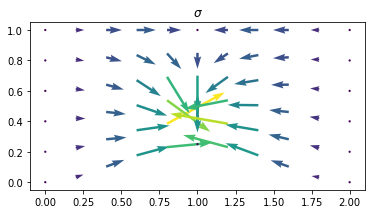

In [6]:
sigmah, uh, lambdah = wh.split()

#output/plot solution
file0 = File("Identity.pvd")
#can't write sigmah to file???
file0.write(sigmah,uh)
fig, axes = plt.subplots()
quiver(sigmah, axes=axes)
axes.set_aspect("equal")
axes.set_title("$\sigma$")
